In [86]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import pearsonr



In [87]:
data_splits = ["complete"]
data_dict = load_data(data_splits)

In [88]:
cp_features = infer_cp_features(data_dict["complete"])
cp_metadata = infer_cp_features(data_dict["complete"], metadata = True)
complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_metadata_df = data_dict["complete"].reindex(cp_metadata, axis="columns")

In [89]:
decoder_beta = keras.models.load_model("../2.train/models/level5Decoder_beta")
decoder_vanilla = keras.models.load_model("../2.train/models/level5Decoder_vanilla")
decoder_mmd = keras.models.load_model("../2.train/models/level5Decoder_mmd")
encoder_beta = keras.models.load_model("../2.train/models/level5Encoder_beta")
encoder_vanilla = keras.models.load_model("../2.train/models/level5Encoder_vanilla")
encoder_mmd = keras.models.load_model("../2.train/models/level5Encoder_mmd")

In [90]:
reconstruction_vanilla = decoder_vanilla.predict(encoder_vanilla.predict(complete_features_df)[0])
reconstruction_beta = decoder_beta.predict(encoder_beta.predict(complete_features_df)[0])
reconstruction_mmd = decoder_mmd.predict(encoder_mmd.predict(complete_features_df)[0])

In [91]:
correlation_vanilla = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_vanilla, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])
correlation_beta = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_beta, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])
correlation_mmd = pd.DataFrame(complete_features_df.corrwith(pd.DataFrame(reconstruction_mmd, columns = cp_features), axis = 1)).assign(moa = pd.read_csv('moa_metadata.csv')['moa'])


In [92]:
correlation_vanilla = correlation_vanilla.dropna()
# correlation_vanilla = correlation_vanilla[correlation_vanilla.moa.str.contains('\|')]

correlation_beta = correlation_beta.dropna()
# correlation_beta = correlation_beta[correlation_beta.moa.str.contains('\|')]

correlation_mmd = correlation_mmd.dropna()
# correlation_mmd = correlation_mmd[correlation_mmd.moa.str.contains('\|')]



In [93]:
vanilla_moa_reproducibility = correlation_vanilla.groupby('moa').median()
beta_moa_reproducibility = correlation_beta.groupby('moa').median()
mmd_moa_reproducibility = correlation_mmd.groupby('moa').median()

In [94]:
vanilla = pd.DataFrame(pd.read_csv('per_moa_performance/level5_vanilla_moa_performance.csv').set_index('MOA')['zscore'])
beta = pd.DataFrame(pd.read_csv('per_moa_performance/level5_beta_moa_performance.csv').set_index('MOA')['zscore'])
mmd = pd.DataFrame(pd.read_csv('per_moa_performance/level5_mmd_moa_performance.csv').set_index('MOA')['zscore'])


In [95]:
vanilla = pd.DataFrame(- np.log(stats.norm.sf(-vanilla)), columns = ['Vanilla MOA pvalue']).set_index(vanilla.index)
beta = pd.DataFrame(- np.log(stats.norm.sf(-beta)), columns = ['Beta MOA pvalue']).set_index(beta.index)
mmd = pd.DataFrame(- np.log(stats.norm.sf(-mmd)), columns = ['MMD MOA pvalue']).set_index(mmd.index)


In [96]:
vanilla

,Vanilla MOA pvalue
MOA,
NFkB pathway inhibitor|proteasome inhibitor,7.122859
microtubule inhibitor|tubulin polymerization inhibitor,7.055568
Aurora kinase inhibitor|JAK inhibitor,6.982753
DNA inhibitor|topoisomerase inhibitor,6.800797
mTOR inhibitor|PI3K inhibitor,6.459888
...,...
CDK inhibitor|glycogen synthase kinase inhibitor,0.006137
benzodiazepine receptor agonist|HDAC inhibitor,0.004508
antimalarial agent|DNA inhibitor,0.001883


In [97]:
vanilla['MOA components reproducibility'] = vanilla_moa_reproducibility.loc[vanilla.index.str.split('\|').str[0]].set_index(vanilla.index) + vanilla_moa_reproducibility.loc[vanilla.index.str.split('\|').str[1]].set_index(vanilla.index)
beta['MOA components reproducibility'] = beta_moa_reproducibility.loc[beta.index.str.split('\|').str[0]].set_index(beta.index) + beta_moa_reproducibility.loc[beta.index.str.split('\|').str[1]].set_index(beta.index)
mmd['MOA components reproducibility'] = mmd_moa_reproducibility.loc[mmd.index.str.split('\|').str[0]].set_index(mmd.index) + mmd_moa_reproducibility.loc[mmd.index.str.split('\|').str[1]].set_index(mmd.index)

In [98]:
# vanilla = pd.concat([vanilla_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-vanilla_predictability))).assign(MOA = vanilla_predictability.index).set_index('MOA')], axis = 1)
# beta = pd.concat([beta_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-beta_predictability))).assign(MOA = beta_predictability.index).set_index('MOA')], axis = 1)
# mmd = pd.concat([mmd_moa_reproducibility, pd.DataFrame(- np.log(stats.norm.sf(-mmd_predictability))).assign(MOA = mmd_predictability.index).set_index('MOA')], axis = 1)


In [99]:
# vanilla.columns = ['MOA reproducibility', 'Vanilla MOA predictability']
# beta.columns = ['MOA reproducibility', 'Beta MOA predictability']
# mmd.columns = ['MOA reproducibility', 'MMD MOA predictability']

In [100]:
sns.set(font_scale=.5)

In [101]:
vanilla

,Vanilla MOA pvalue,MOA components reproducibility
MOA,,
NFkB pathway inhibitor|proteasome inhibitor,7.122859,1.909088
microtubule inhibitor|tubulin polymerization inhibitor,7.055568,1.661931
Aurora kinase inhibitor|JAK inhibitor,6.982753,1.858270
DNA inhibitor|topoisomerase inhibitor,6.800797,1.907689
mTOR inhibitor|PI3K inhibitor,6.459888,1.811119
...,...,...
CDK inhibitor|glycogen synthase kinase inhibitor,0.006137,1.579115
benzodiazepine receptor agonist|HDAC inhibitor,0.004508,1.842450
antimalarial agent|DNA inhibitor,0.001883,1.881038


In [102]:
vanilla = pd.concat([vanilla, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_vanilla.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)
beta = pd.concat([beta, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_beta.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)
mmd = pd.concat([mmd, pd.concat([pd.read_csv('moas.csv'), pd.read_csv('L2_distances/level5_PEARSON_general_mmd.tsv', sep = '\t').dropna()], axis = 1)[['moa','Unshuffled']].set_index('moa')], axis = 1)

In [103]:
vanilla = vanilla.rename(columns={"Unshuffled": "Vanilla MOA predictability"})
beta = beta.rename(columns={"Unshuffled": "Beta MOA predictability"})
mmd = mmd.rename(columns={"Unshuffled": "MMD MOA predictability"})

<AxesSubplot:xlabel='MOA components reproducibility', ylabel='MMD MOA predictability'>

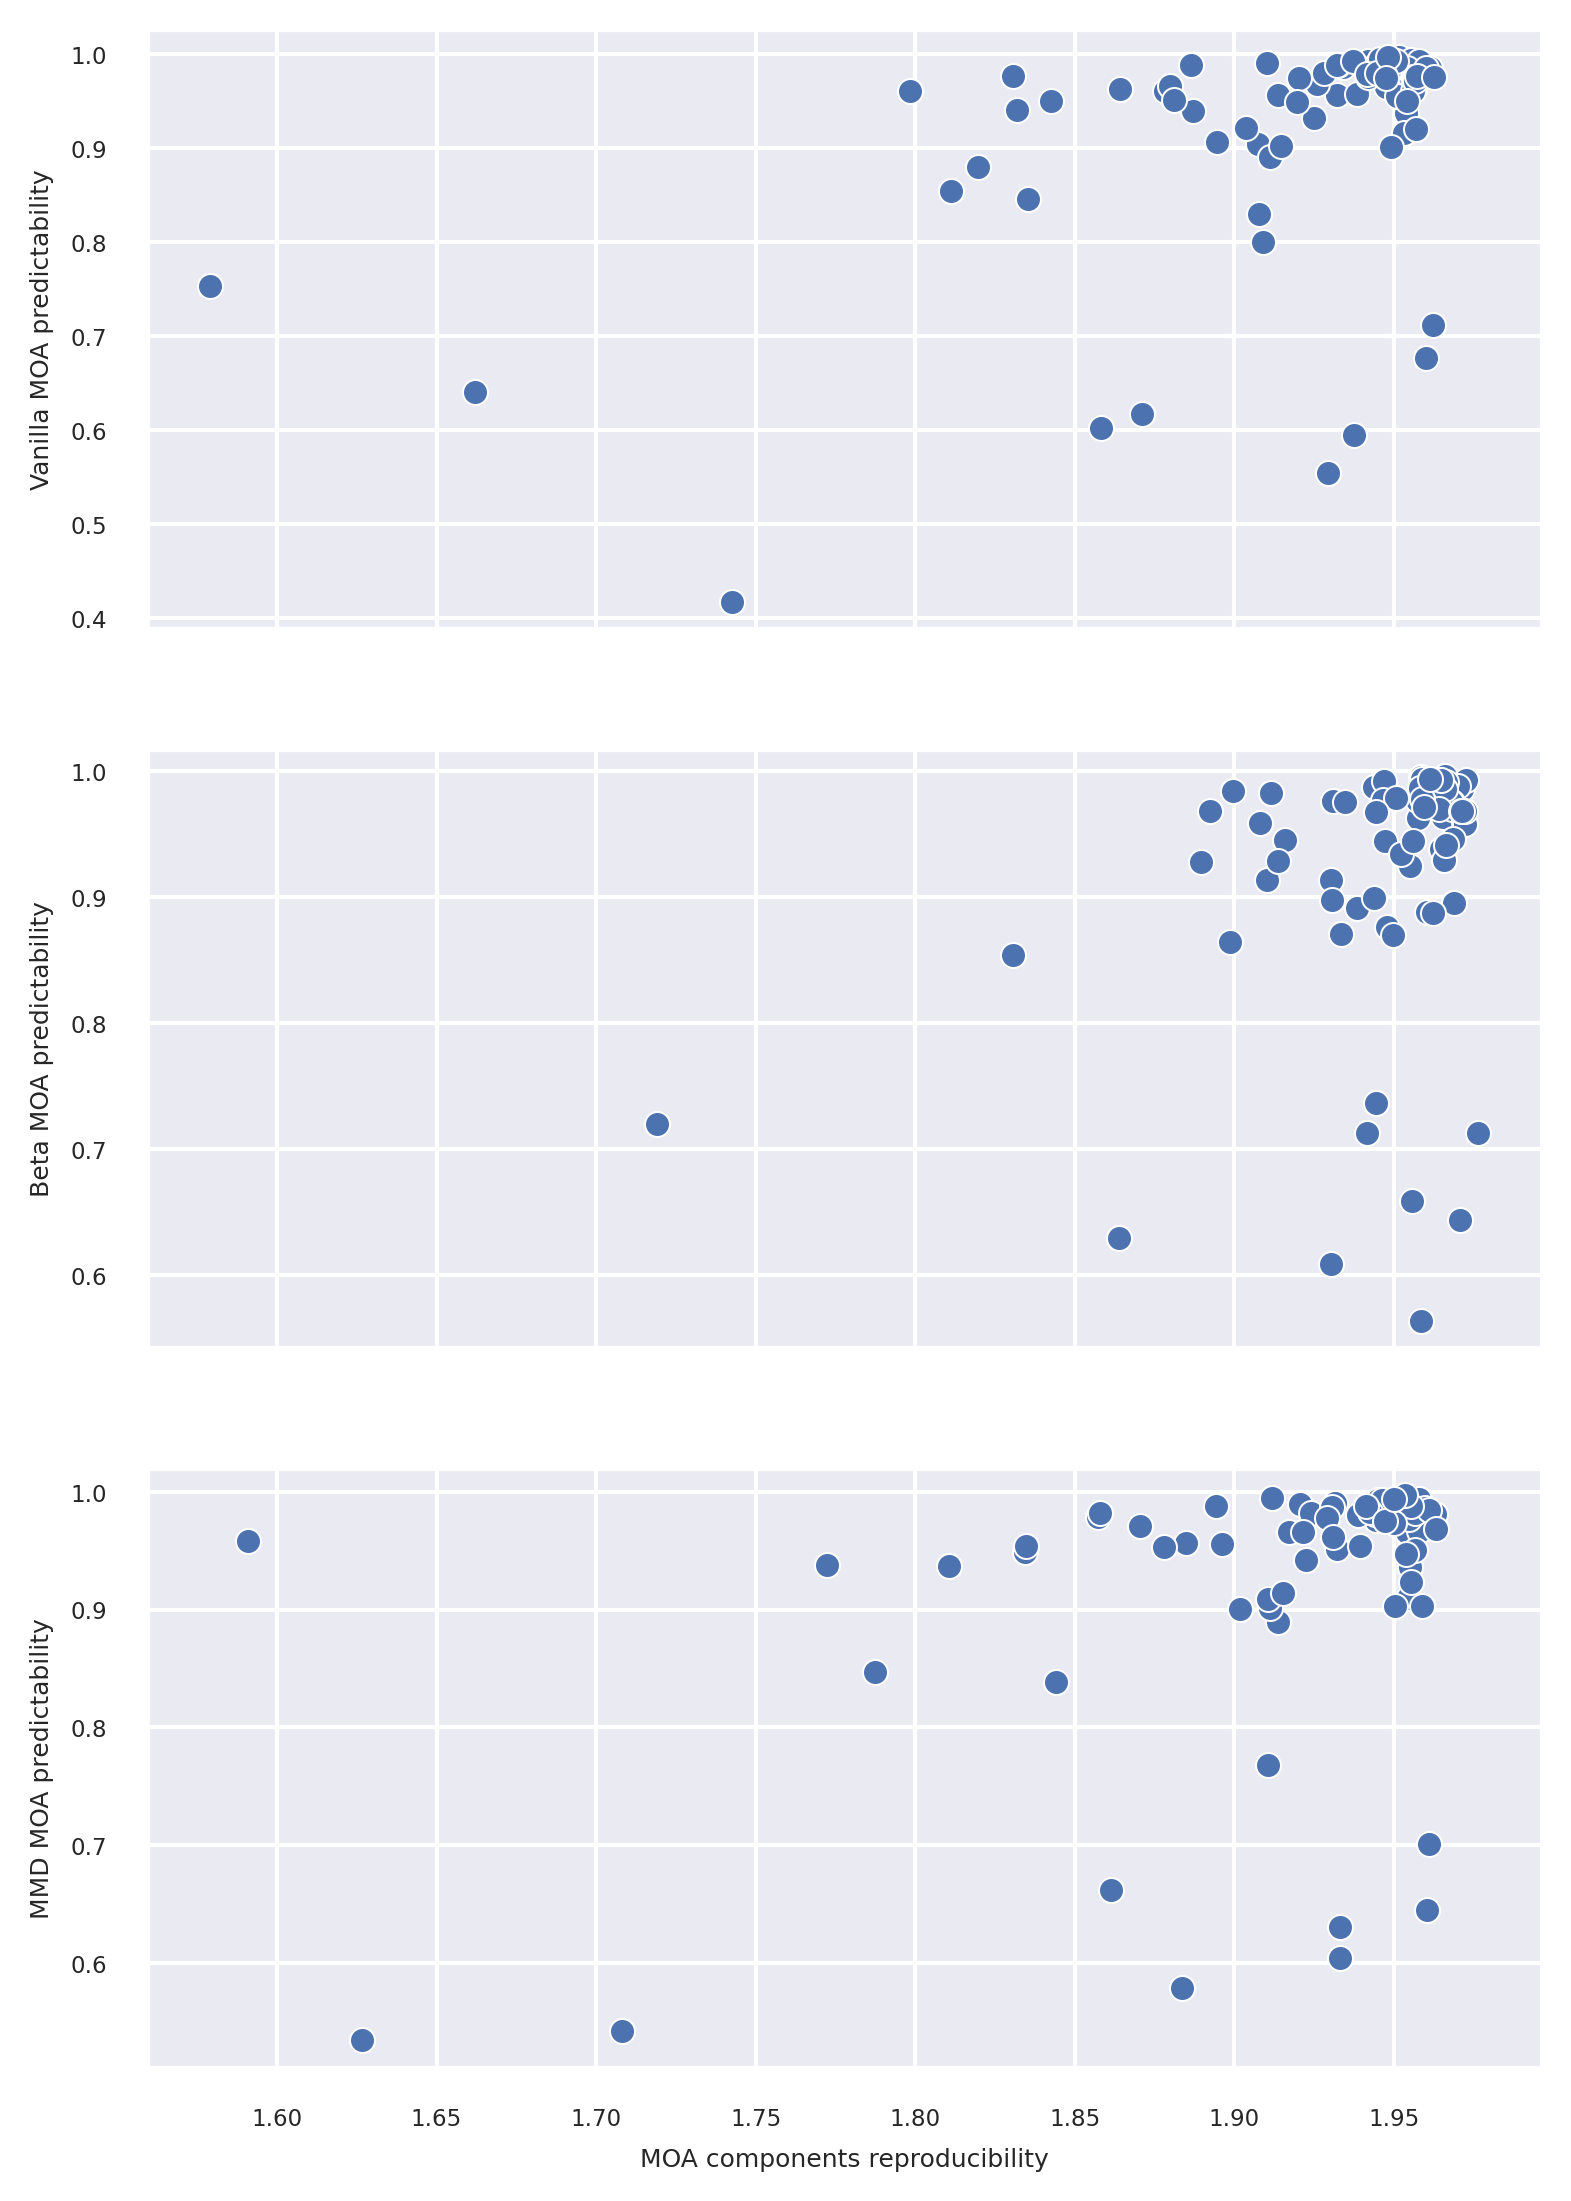

In [106]:
fig, ((ax1, ax2, ax3)) = plt.subplots(3,1, figsize=(6, 9), dpi=300, sharex = True)
sns.scatterplot(ax = ax1, data = vanilla, x = 'MOA components reproducibility', y = 'Vanilla MOA predictability')
sns.scatterplot(ax = ax2, data = beta, x = 'MOA components reproducibility', y = 'Beta MOA predictability')
sns.scatterplot(ax = ax3, data = mmd, x = 'MOA components reproducibility', y = 'MMD MOA predictability')


In [ ]:
print(pearsonr(vanilla['Unshuffled'], vanilla['MOA components reproducibility'])[0])
print(pearsonr(beta['Unshuffled'], beta['MOA components reproducibility'])[0])
print(pearsonr(mmd['Unshuffled'], mmd['MOA components reproducibility']))

In [107]:
print(pearsonr(vanilla['Vanilla MOA predictability'], vanilla['MOA components reproducibility'])[0])
print(pearsonr(beta['Beta MOA predictability'], beta['MOA components reproducibility'])[0])
print(pearsonr(mmd['MMD MOA predictability'], mmd['MOA components reproducibility'])[0])

0.47759192609389
0.335177416480579
0.4041211757606379
